# Import Libraries

Here we import all the libraries needed for loading, processing, and visualizing the dataset

In [1]:
# Import the needed libraries
import kagglehub
import os
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px  # For interactive plots
import plotly.io as pio
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# Needed for some non-Seaborn-based enhancements
from scipy.stats import gaussian_kde
# Principal Component Analysis
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# About the Dataset
---

This dataset consists of data collected as part of a research project involving chemical sensors in a field enclosure. This enclosure monitored air quality for over a year.

The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level, within an Italian city. Data were recorded from March 2004 to February 2005 (one year), representing the longest freely available recordings of on-field deployed air quality chemical sensor devices' responses. Ground Truth hourly averaged concentrations for CO, Non-Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx), and Nitrogen Dioxide (NO2) were provided by a co-located reference certified analyzer. Evidence of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required), eventually affecting sensors' concentration estimation capabilities. Missing values are tagged with the -200 value.

*Feature List*:

Variable Name | Role | Type | Description | Units | Missing Values
--- | --- | --- | --- | --- | --- 
Date | Feature | Date | | | no
Time | Feature | Categorical | | | no
CO(GT) | Feature | Integer | True | hourly averaged concentration CO in mg/m^3 (reference analyzer) | mg/m^3 | no
PT08.S1(CO) | Feature | Categorical | hourly averaged sensor response (nominally CO targeted) | | no
NMHC(GT) | Feature | Integer | True | hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer) | microg/m^3 | no
C6H6(GT) | Feature | Continuous | True | hourly averaged Benzene concentration in microg/m^3 (reference analyzer) | microg/m^3 | no
PT08.S2(NMHC) | Feature | Categorical | hourly averaged sensor response (nominally NMHC targeted) | | no
NOx(GT) | Feature | Integer | True | hourly averaged NOx concentration in ppb (reference analyzer) | ppb | no
PT08.S3(NOx) | Feature | Categorical | hourly averaged sensor response (nominally NOx targeted) | | no
NO2(GT) | Feature | Integer | True | hourly averaged NO2 concentration in microg/m^3 (reference analyzer) | microg/m^3 | no
PT08.S4(NO2) | Feature | Categorical | hourly averaged sensor response (nominally NO2 targeted) | | no
PT08.S5(O3) | Feature | Categorical	hourly averaged sensor response (nominally O3 targeted) | | no
T | Feature | Continuous | Temperature | °C | no
RH | Feature | Continuous | Relative Humidity | % | no
AH | Feature | Continuous | Absolute Humidity | | no

# Load the Libraries from text files
---

This data comes in both a CSV file and an XLSX file. The XLSX file has higher fidelity, and the values were not rounded or truncated, and can provide better accuracy. Data is loaded from the CSV file, and then the columns are made lowercase, and a combined datetime field is made from the individual date and time columns.

Parentheses are removed from column names, and the initial parenthesis is replaced with an underscore.

## Load the Train data from text files

We know the data is already partitioned into a training set and a test set, so we just load the training data set directly.

In [2]:
# Load data
df = pd.read_excel("AirQualityUCI.xlsx")

# Drop missing values
df = df.dropna()
# Clean column names
df.columns = df.columns.str.strip().str.lower().str.replace('(', '_').str.replace(')', '')

# Combine 'Date' and 'Time' into a single string, then parse with the correct format
datetime_str = df['date'].astype(str) + ' ' + df['time'].astype(str)
df['datetime'] = pd.to_datetime(datetime_str, format='%Y-%m-%d %H:%M:%S')

# Set default renderer to 'png' for static images in plotly (3D graphs)
pio.renderers.default = "png"  # or "svg" for vector graphics

# Output data info and samples
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          9357 non-null   datetime64[ns]
 1   time          9357 non-null   object        
 2   co_gt         9357 non-null   float64       
 3   pt08.s1_co    9357 non-null   float64       
 4   nmhc_gt       9357 non-null   int64         
 5   c6h6_gt       9357 non-null   float64       
 6   pt08.s2_nmhc  9357 non-null   float64       
 7   nox_gt        9357 non-null   float64       
 8   pt08.s3_nox   9357 non-null   float64       
 9   no2_gt        9357 non-null   float64       
 10  pt08.s4_no2   9357 non-null   float64       
 11  pt08.s5_o3    9357 non-null   float64       
 12  t             9357 non-null   float64       
 13  rh            9357 non-null   float64       
 14  ah            9357 non-null   float64       
 15  datetime      9357 non-null   datetime

# Sample Feature Exploration (Chemical sensor data details)

This is a brief overview of the data collected from the field device that had chemical sensors installed; additionally, hourly averages are included for each of the five chemical sensors (alongside the raw data samples)

## Chemical Hourly Sensor Pairplot by Temperature
---

<Figure size 1600x1600 with 0 Axes>

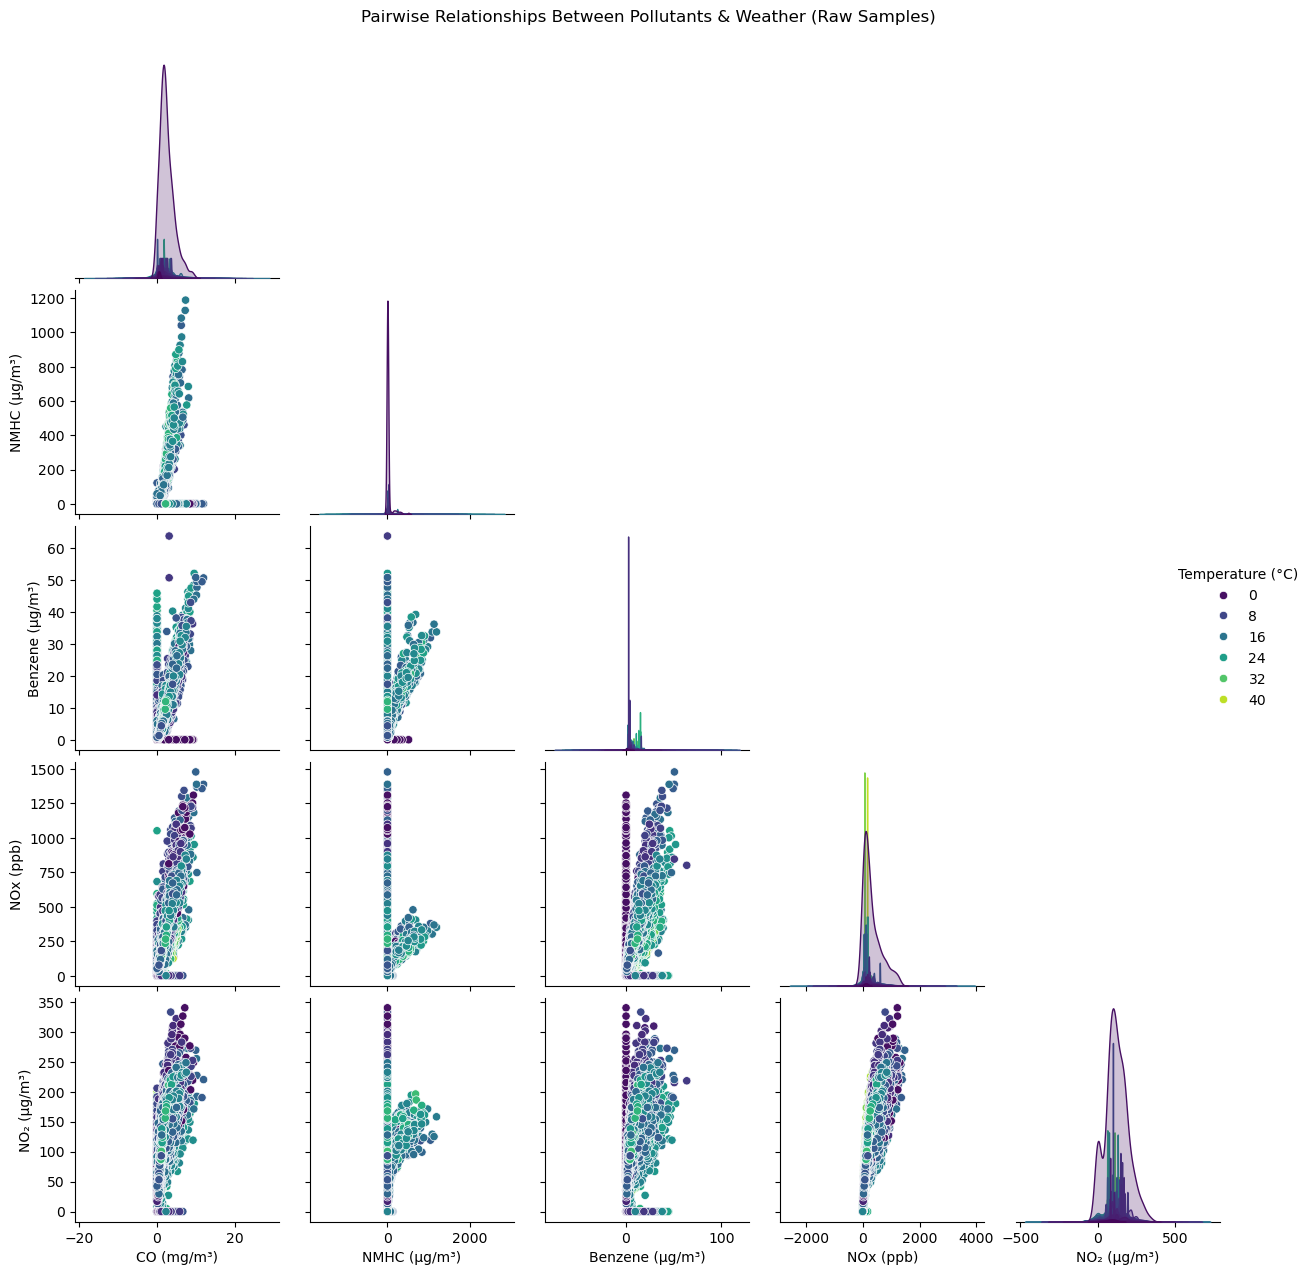

In [3]:
# Categories to filter on
categories = ['co_gt', 'nmhc_gt', 'c6h6_gt',
              'nox_gt', 'no2_gt', 't']

# Setup the figure size
plt.figure(figsize=(16, 16))  # This sets the overall figure size

# Pairplot for key pollutants
pairplt = sns.pairplot(df[categories], 
             diag_kind='kde', corner=True, hue='t', palette='viridis', height=2.5)
plt.suptitle('Pairwise Relationships Between Pollutants & Weather (Raw Samples)', y=1.02)

# Column names
column_labels = {
    'co_gt': 'CO (mg/m³)',
    'nmhc_gt': 'NMHC (µg/m³)',
    'c6h6_gt': 'Benzene (µg/m³)',
    'nox_gt': 'NOx (ppb)',
    'no2_gt': 'NO₂ (µg/m³)',
    't': 'Temperature (°C)'
}

# Apply custom labels
for ax in pairplt.axes.flat:
    if ax is not None:  # Check if the axis exists
        xlabel = ax.get_xlabel()
        ylabel = ax.get_ylabel()
        if xlabel in column_labels:
            ax.set_xlabel(column_labels[xlabel], fontsize=10)
        if ylabel in column_labels:
            ax.set_ylabel(column_labels[ylabel], fontsize=10)

# Update the color bar label
pairplt._legend.set_title("Temperature (°C)")

# Save the graph as a PNG
plt.savefig(
    'JoshuaSummers_temperature-chemical-sensor-exploration-pairplot.png',
    dpi=300,               # High resolution
    transparent=False,     # Transparent background
    bbox_inches='tight'   # Remove extra whitespace
)
# Show the visualization
plt.show()

## Chemical Hourly Average Pairplot by Temperature
---

<Figure size 1600x1600 with 0 Axes>

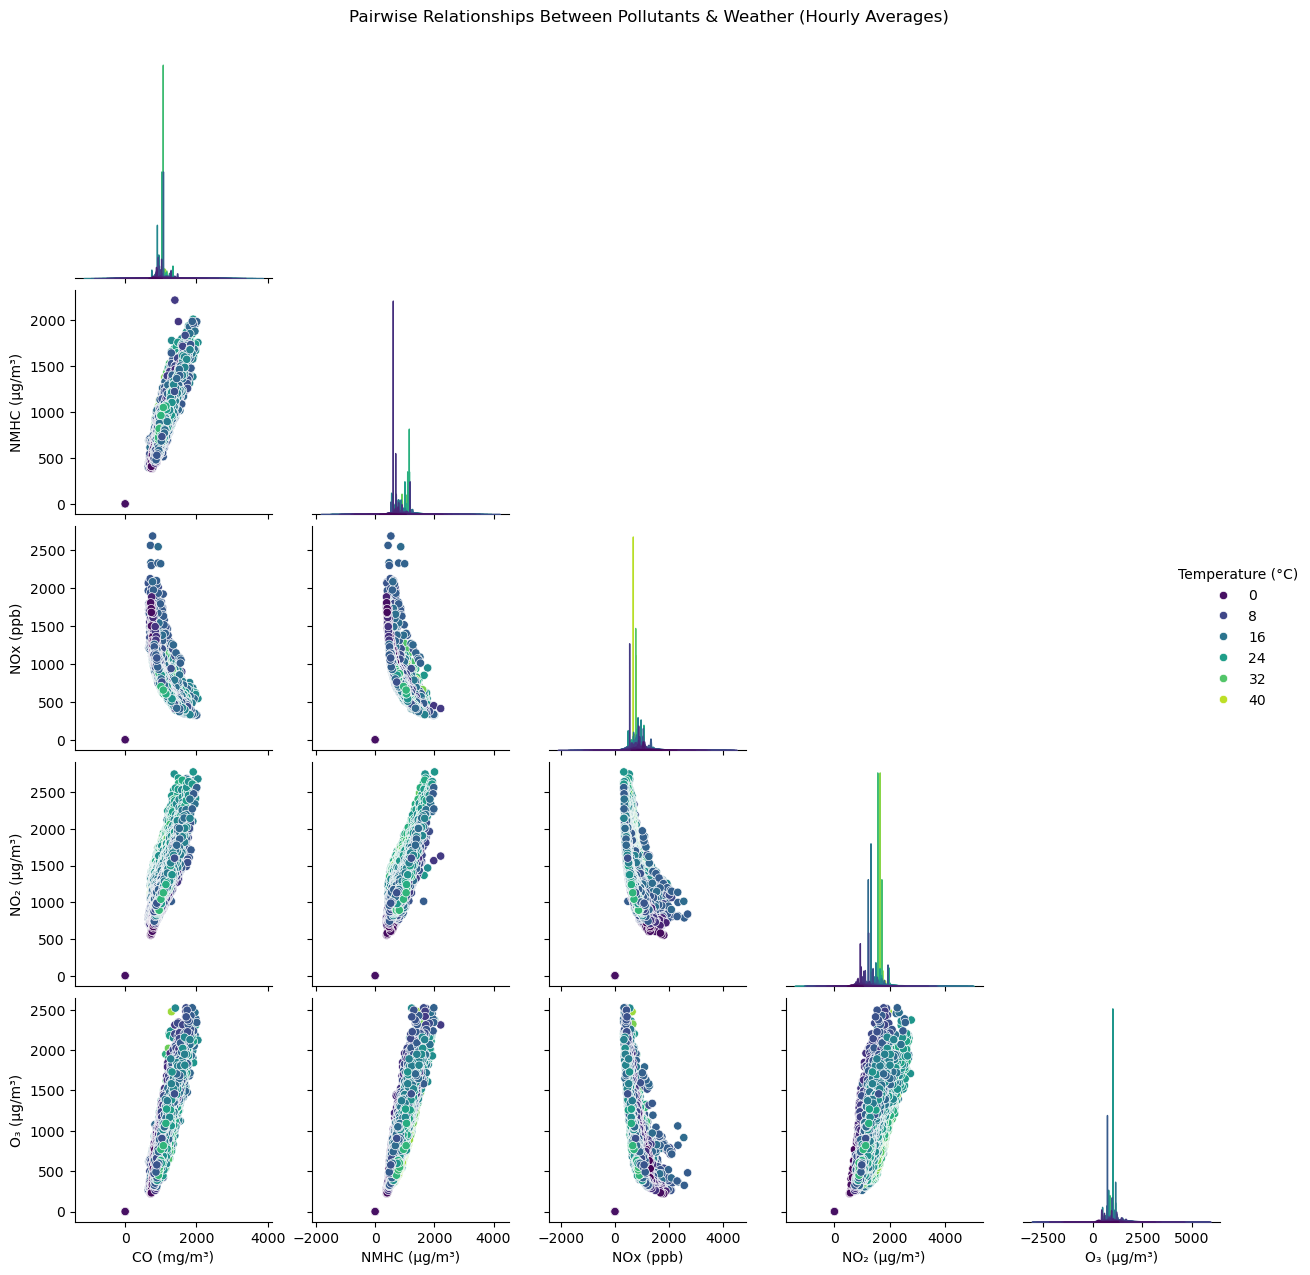

In [4]:
# Categories to filter on
categories = ['pt08.s1_co', 'pt08.s2_nmhc', 'pt08.s3_nox', 
              'pt08.s4_no2', 'pt08.s5_o3', 't']

# Setup the figure size
plt.figure(figsize=(16, 16))  # This sets the overall figure size

# Pairplot for key pollutants
pairplt = sns.pairplot(df[categories], 
             diag_kind='kde', corner=True, hue='t', palette='viridis', height=2.5)
plt.suptitle('Pairwise Relationships Between Pollutants & Weather (Hourly Averages)', y=1.02)

# Column names
column_labels = {
    'pt08.s1_co': 'CO (mg/m³)',
    'pt08.s2_nmhc': 'NMHC (µg/m³)',
    'pt08.s3_nox': 'NOx (ppb)',
    'pt08.s4_no2': 'NO₂ (µg/m³)',
    'pt08.s5_o3': 'O₃ (µg/m³)',
    't': 'Temperature (°C)'
}

# Apply custom labels
for ax in pairplt.axes.flat:
    if ax is not None:  # Check if the axis exists
        xlabel = ax.get_xlabel()
        ylabel = ax.get_ylabel()
        if xlabel in column_labels:
            ax.set_xlabel(column_labels[xlabel], fontsize=10)
        if ylabel in column_labels:
            ax.set_ylabel(column_labels[ylabel], fontsize=10)

# Update the color bar label
pairplt._legend.set_title("Temperature (°C)")

# Save the graph as a PNG
plt.savefig(
    'JoshuaSummers_temperature-chemical-average-exploration-pairplot.png',
    dpi=300,               # High resolution
    transparent=False,     # Transparent background
    bbox_inches='tight'   # Remove extra whitespace
)
# Show the visualization
plt.show()

## Chemical Hourly Sensor Pairplot by Absolute Humidity
---

<Figure size 1600x1600 with 0 Axes>

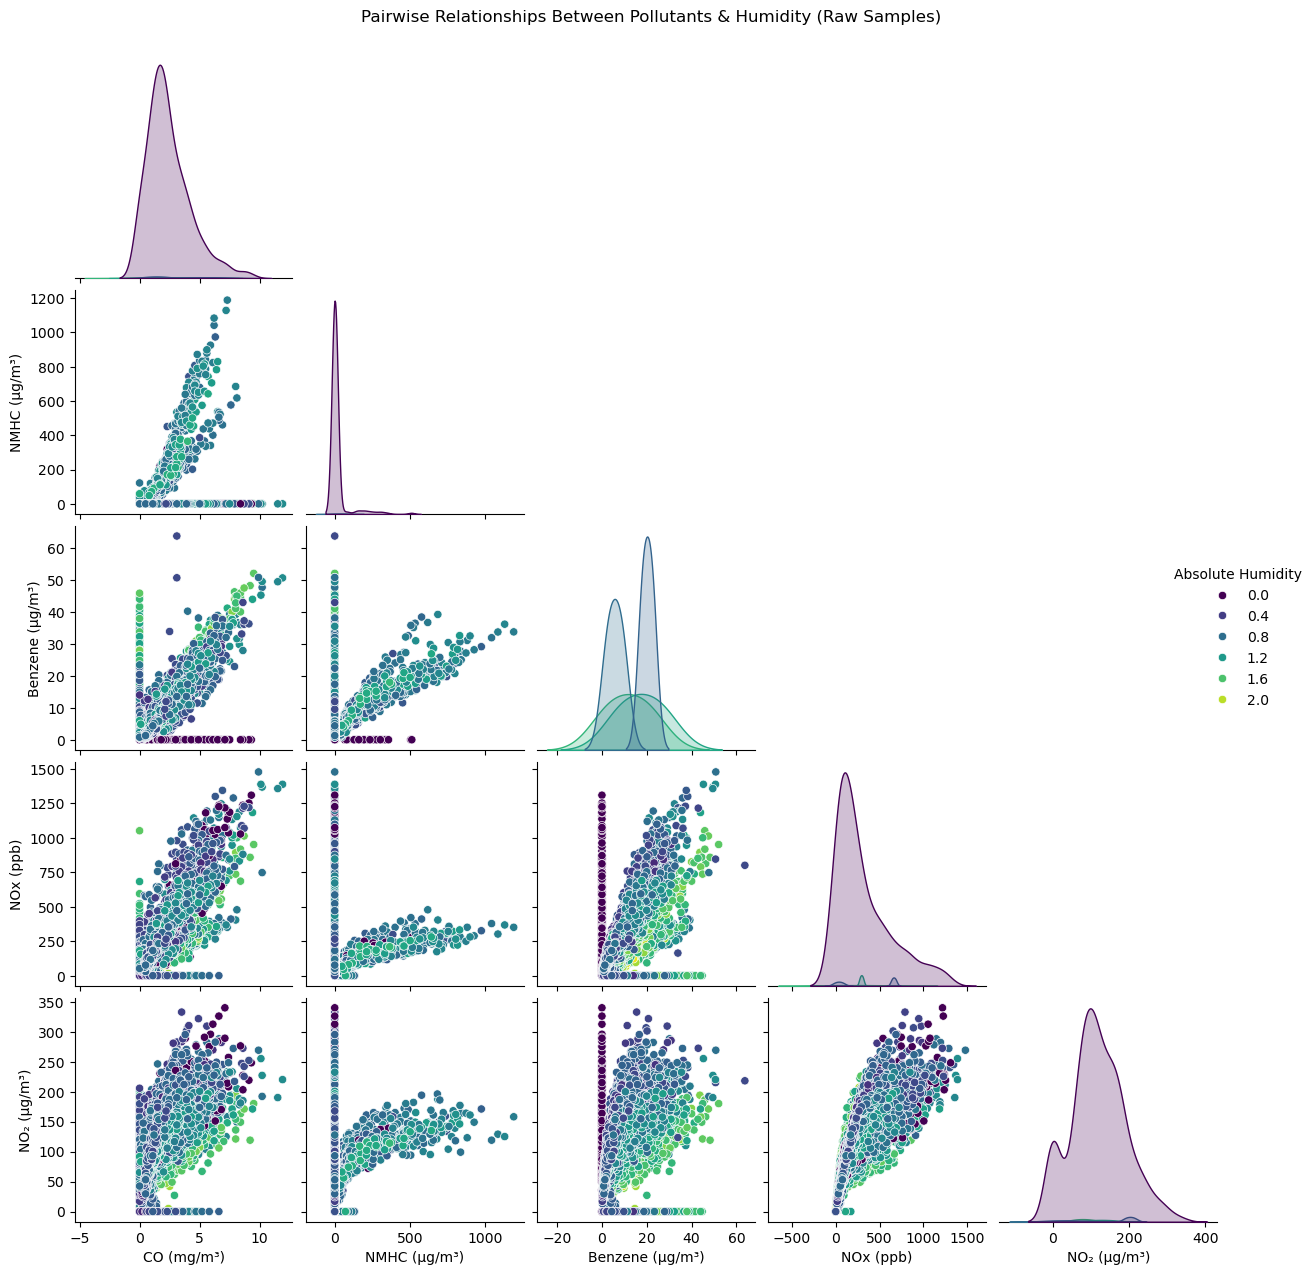

In [5]:
# Categories to filter on
categories = ['co_gt', 'nmhc_gt', 'c6h6_gt',
              'nox_gt', 'no2_gt', 'ah']

# Setup the figure size
plt.figure(figsize=(16, 16))  # This sets the overall figure size

# Pairplot for key pollutants
pairplt = sns.pairplot(df[categories], 
             diag_kind='kde', corner=True, hue='ah', palette='viridis', height=2.5)
plt.suptitle('Pairwise Relationships Between Pollutants & Humidity (Raw Samples)', y=1.02)

# Column names
column_labels = {
    'co_gt': 'CO (mg/m³)',
    'nmhc_gt': 'NMHC (µg/m³)',
    'c6h6_gt': 'Benzene (µg/m³)',
    'nox_gt': 'NOx (ppb)',
    'no2_gt': 'NO₂ (µg/m³)',
    't': 'Temperature (°C)'
}

# Apply custom labels
for ax in pairplt.axes.flat:
    if ax is not None:  # Check if the axis exists
        xlabel = ax.get_xlabel()
        ylabel = ax.get_ylabel()
        if xlabel in column_labels:
            ax.set_xlabel(column_labels[xlabel], fontsize=10)
        if ylabel in column_labels:
            ax.set_ylabel(column_labels[ylabel], fontsize=10)

# Update the color bar label
pairplt._legend.set_title("Absolute Humidity")

# Save the graph as a PNG
plt.savefig(
    'JoshuaSummers_humidity-chemical-sensor-exploration-pairplot.png',
    dpi=300,               # High resolution
    transparent=False,     # Transparent background
    bbox_inches='tight'   # Remove extra whitespace
)
# Show the visualization
plt.show()

## Chemical Hourly Average Pairplot by Absolute Humidity
---

<Figure size 1600x1600 with 0 Axes>

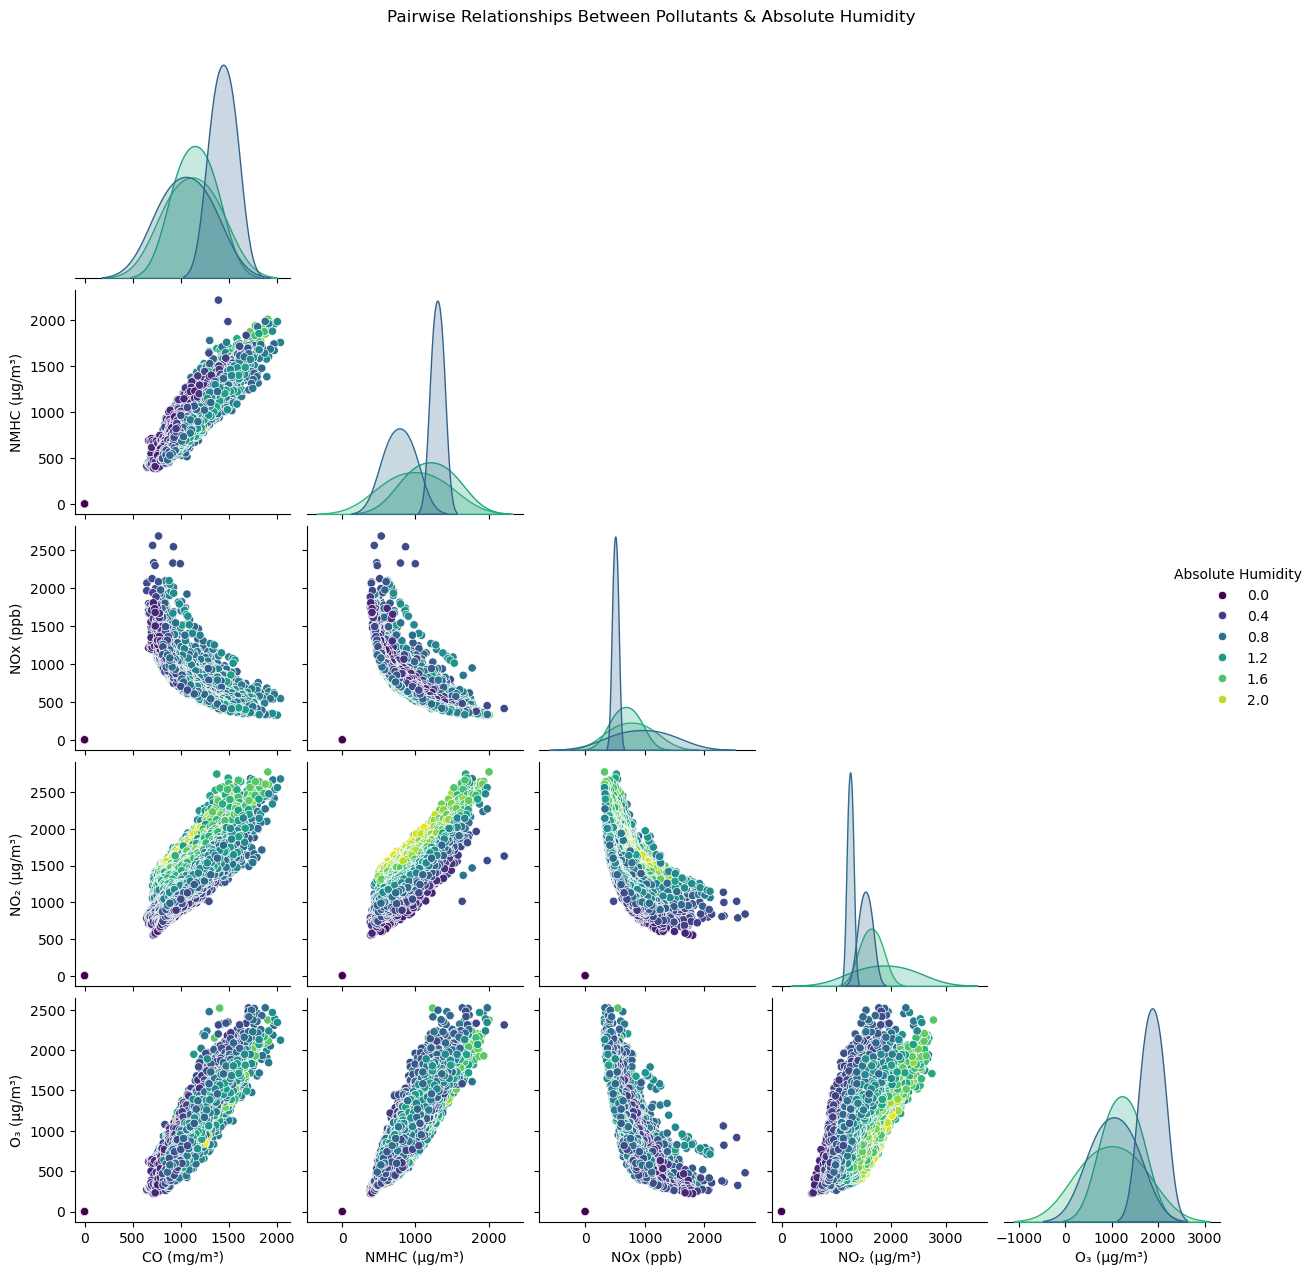

In [6]:
# Categories to filter on
categories = ['pt08.s1_co', 'pt08.s2_nmhc', 'pt08.s3_nox',
              'pt08.s4_no2', 'pt08.s5_o3', 'ah']

# Setup the figure size
plt.figure(figsize=(16, 16))  # This sets the overall figure size

# Pairplot for key pollutants
pairplt = sns.pairplot(df[categories], 
             diag_kind='kde', corner=True, hue='ah', palette='viridis', height=2.5)
plt.suptitle('Pairwise Relationships Between Pollutants & Absolute Humidity', y=1.02)

# Column names
column_labels = {
    'pt08.s1_co': 'CO (mg/m³)',
    'pt08.s2_nmhc': 'NMHC (µg/m³)',
    'pt08.s3_nox': 'NOx (ppb)',
    'pt08.s4_no2': 'NO₂ (µg/m³)',
    'pt08.s5_o3': 'O₃ (µg/m³)',
    't': 'Temperature (°C)'
}

# Apply custom labels
for ax in pairplt.axes.flat:
    if ax is not None:  # Check if the axis exists
        xlabel = ax.get_xlabel()
        ylabel = ax.get_ylabel()
        if xlabel in column_labels:
            ax.set_xlabel(column_labels[xlabel], fontsize=10)
        if ylabel in column_labels:
            ax.set_ylabel(column_labels[ylabel], fontsize=10)

# Update the color bar label
pairplt._legend.set_title("Absolute Humidity")

# Save the graph as a PNG
plt.savefig(
    'JoshuaSummers_humidity-chemical-average-exploration-pairplot.png',
    dpi=300,               # High resolution
    transparent=False,     # Transparent background
    bbox_inches='tight'   # Remove extra whitespace
)
# Show the visualization
plt.show()

## Chemical Exploration by Temperature and Humidity
---

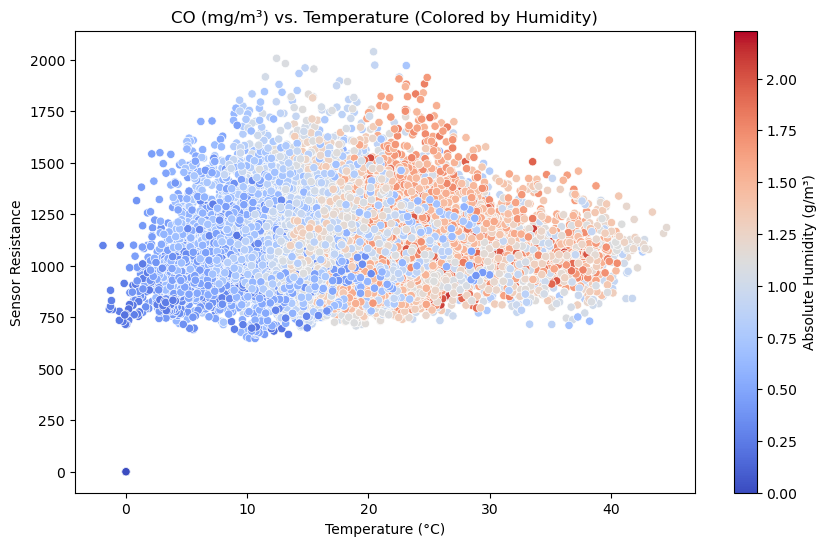

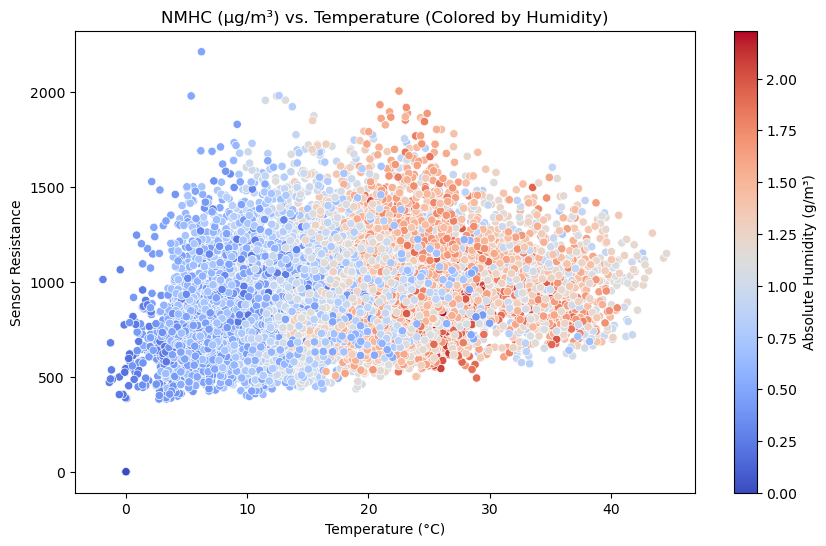

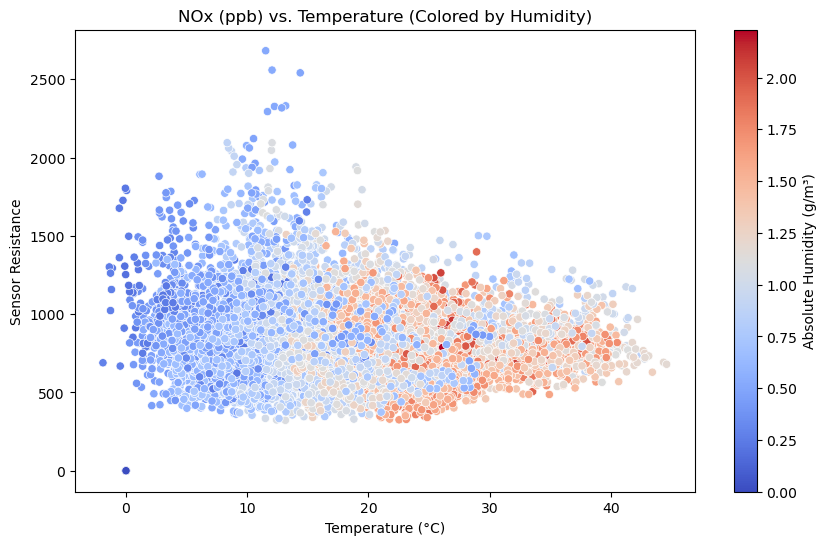

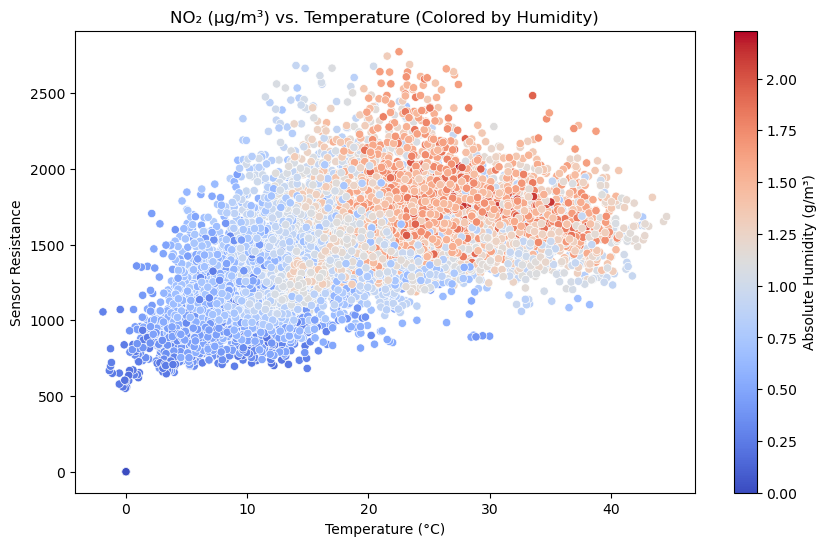

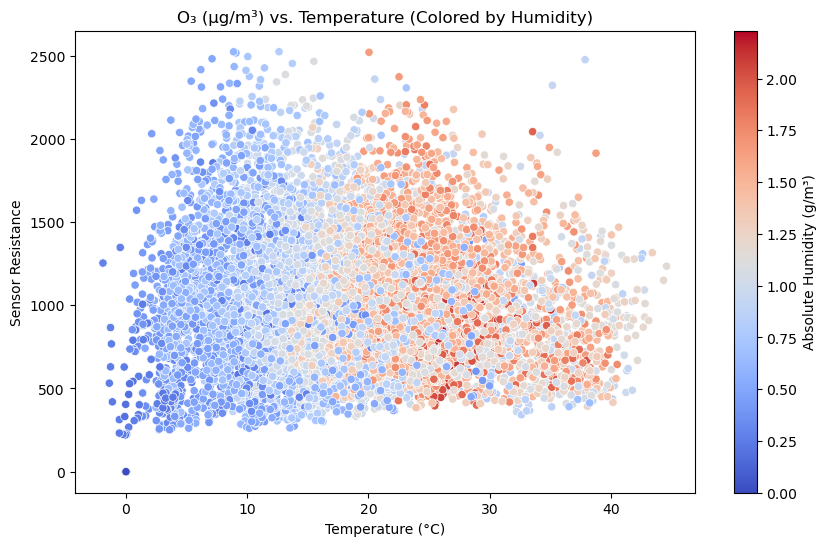

In [7]:
# Categories to filter on
categories = ['pt08.s1_co', 'pt08.s2_nmhc', 'pt08.s3_nox', 'pt08.s4_no2', 'pt08.s5_o3']

# Column names
column_labels = {
    'pt08.s1_co': 'CO (mg/m³)',
    'pt08.s2_nmhc': 'NMHC (µg/m³)',
    'pt08.s3_nox': 'NOx (ppb)',
    'pt08.s4_no2': 'NO₂ (µg/m³)',
    'pt08.s5_o3': 'O₃ (µg/m³)',
    't': 'Temperature (°C)'
}

# File names
file_labels = {
    'pt08.s1_co': 'co',
    'pt08.s2_nmhc': 'nmhc',
    'pt08.s3_nox': 'nox',
    'pt08.s4_no2': 'no2',
    'pt08.s5_o3': 'o3',
}

# Generate a figure for each sensor
for sensor in categories:
    plt.figure(figsize=(10, 6))
    ax = sns.scatterplot(data=df, x='t', y=sensor, hue='ah', palette='coolwarm')
    
    # Colorbar setup
    norm = plt.Normalize(df['ah'].min(), df['ah'].max())
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm.set_array([])
    ax.get_legend().remove()
    plt.colorbar(sm, ax=ax, label='Absolute Humidity (g/m³)')

    # Setup the layout
    plt.title(f'{column_labels[sensor]} vs. Temperature (Colored by Humidity)')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Sensor Resistance')

    # Save the graph as a PNG
    plt.savefig(
        f'JoshuaSummers_temperature-humidity-sensor-exploration-scatterplot-{file_labels[sensor]}.png',
        dpi=300,               # High resolution
        transparent=False,     # Transparent background
        bbox_inches='tight'   # Remove extra whitespace
    )
    # Show the visualization
    plt.show()

## Chemical Hourly Sensor Boxplot by Absolute Humidity

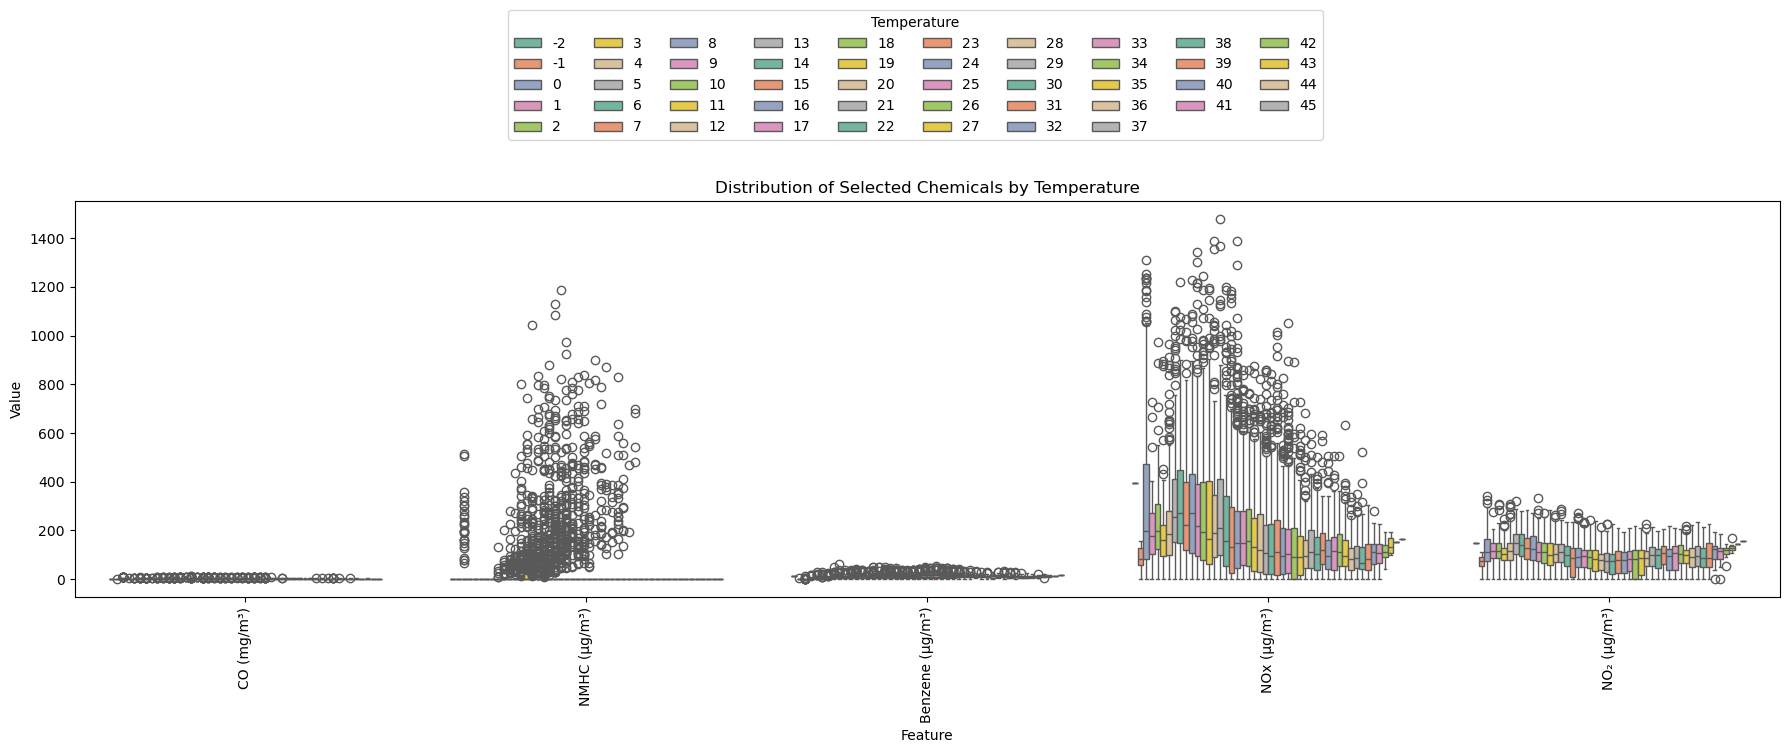

In [8]:
# Categories to filter on
categories = ['co_gt', 'nmhc_gt', 'c6h6_gt',
              'nox_gt', 'no2_gt']

# Round temperature to integers before melting
df['t_rounded'] = df['t'].round().astype(int)

# Visualize multiple features across ActivityName by melting the data together
melted_df = df.melt(id_vars='t_rounded', value_vars=categories, var_name='Feature', value_name='Value')

# Define custom labels for each feature
column_labels = {
    'co_gt': 'CO (mg/m³)',
    'nmhc_gt': 'NMHC (µg/m³)',
    'c6h6_gt': 'Benzene (µg/m³)',
    'nox_gt': 'NOx (µg/m³)',
    'no2_gt': 'NO₂ (µg/m³)',
    't': 'Temperature (°C)'
}

# Replace default feature names with custom labels
melted_df['Feature'] = melted_df['Feature'].map(column_labels)

# Setup the plot
plt.figure(figsize=(18, 10))
sns.boxplot(data=melted_df, x='Feature', y='Value', hue='t_rounded', palette='Set2')
# Define the graph details
# Rotate x-tick labels and align them
plt.xticks(rotation=90)  # Align right for better readability
plt.title('Distribution of Selected Chemicals by Temperature')
# Move legend above
plt.legend(title='Temperature', bbox_to_anchor=(0.25, 1.50), loc='upper left', ncol=10)

# Save the graph as a PNG
plt.savefig(
    'JoshuaSummers_temperature-chemical-sensor-exploration-boxplot.png',
    dpi=300,               # High resolution
    transparent=False,     # Transparent background
    bbox_inches='tight'   # Remove extra whitespace
)
# Adjust layout to make room for legend and rotated ticks
plt.tight_layout(rect=[0, 0, 1, 0.95])  # reserve top 5% space for legend
plt.show()

## Chemical Hourly Average Boxplot by Absolute Humidity

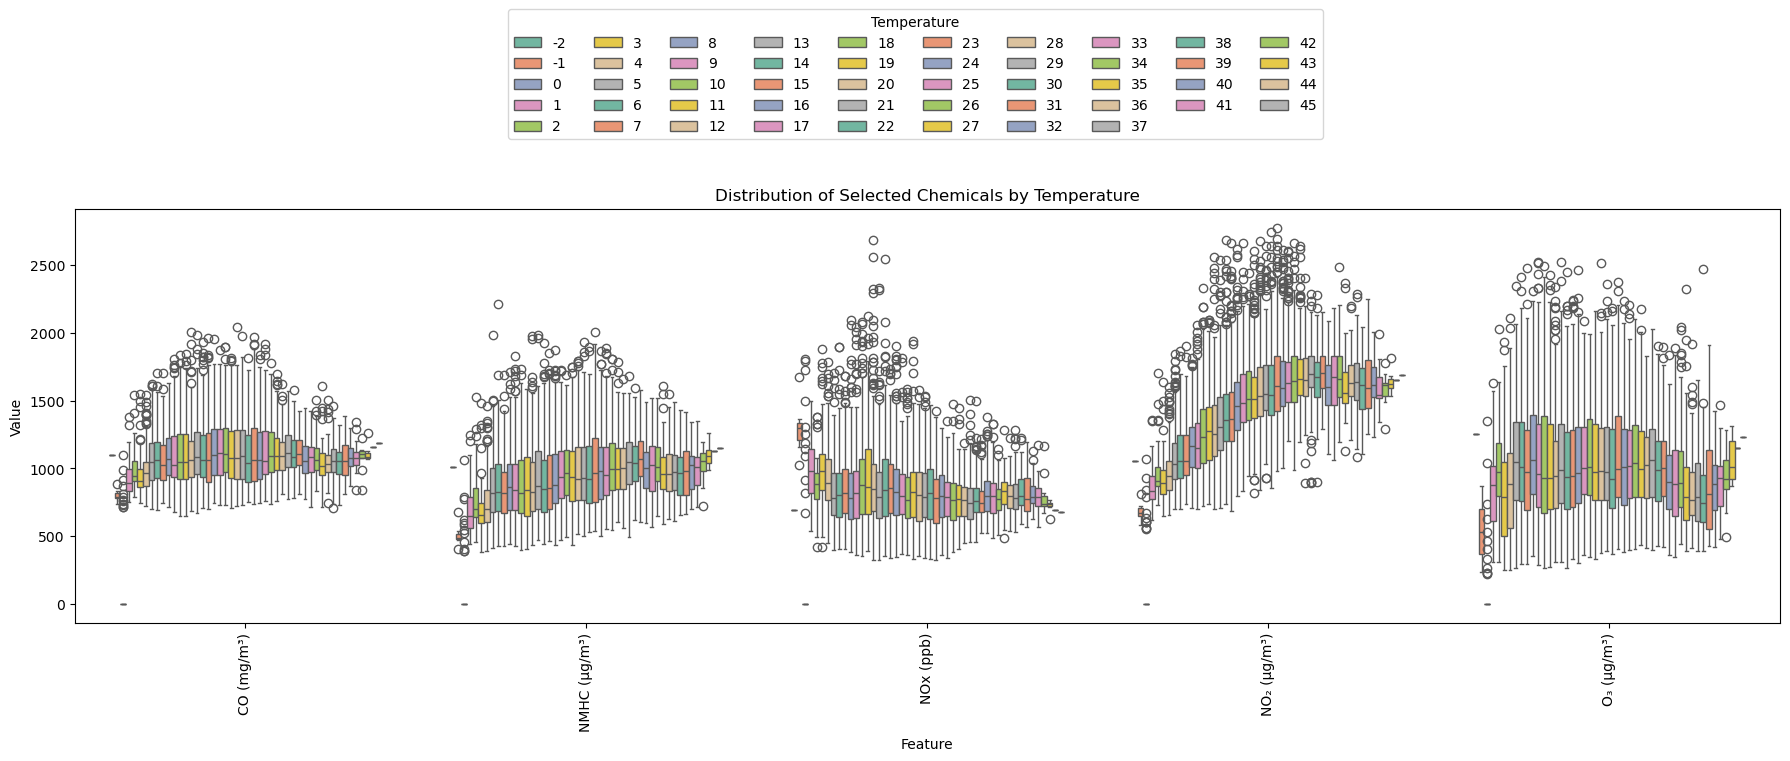

In [9]:
# Categories to filter on
categories = ['pt08.s1_co', 'pt08.s2_nmhc', 'pt08.s3_nox',
              'pt08.s4_no2', 'pt08.s5_o3']

# Round temperature to integers before melting
df['t_rounded'] = df['t'].round().astype(int)

# Visualize multiple features across ActivityName by melting the data together
melted_df = df.melt(id_vars='t_rounded', value_vars=categories, var_name='Feature', value_name='Value')

# Define custom labels for each feature
column_labels = {
    'pt08.s1_co': 'CO (mg/m³)',
    'pt08.s2_nmhc': 'NMHC (µg/m³)',
    'pt08.s3_nox': 'NOx (ppb)',
    'pt08.s4_no2': 'NO₂ (µg/m³)',
    'pt08.s5_o3': 'O₃ (µg/m³)',
    't': 'Temperature (°C)'
}

# Replace default feature names with custom labels
melted_df['Feature'] = melted_df['Feature'].map(column_labels)

# Setup the plot
plt.figure(figsize=(18, 10))
sns.boxplot(data=melted_df, x='Feature', y='Value', hue='t_rounded', palette='Set2')
# Define the graph details
# Rotate x-tick labels and align them
plt.xticks(rotation=90)  # Align right for better readability
plt.title('Distribution of Selected Chemicals by Temperature')
# Move legend above
plt.legend(title='Temperature', bbox_to_anchor=(0.25, 1.50), loc='upper left', ncol=10)

# Save the graph as a PNG
plt.savefig(
    'JoshuaSummers_temperature-chemical-average-exploration-boxplot.png',
    dpi=300,               # High resolution
    transparent=False,     # Transparent background
    bbox_inches='tight'   # Remove extra whitespace
)
# Adjust layout to make room for legend and rotated ticks
plt.tight_layout(rect=[0, 0, 1, 0.95])  # reserve top 5% space for legend
plt.show()

# Principal Component Analysis (PCA)
---

This visualization will show us all the sensor data points, but reduced to three dimensions, to allow for 3D visualization. We reduce the groups, but maintain as much of the original variance as possible by using the following PCA sets:

- PCA1 (CO/NOx Dominant)
- PCA2 (Benzene/NO2 Dominant)
- PCA3 (Temp/Humidity Dominant)

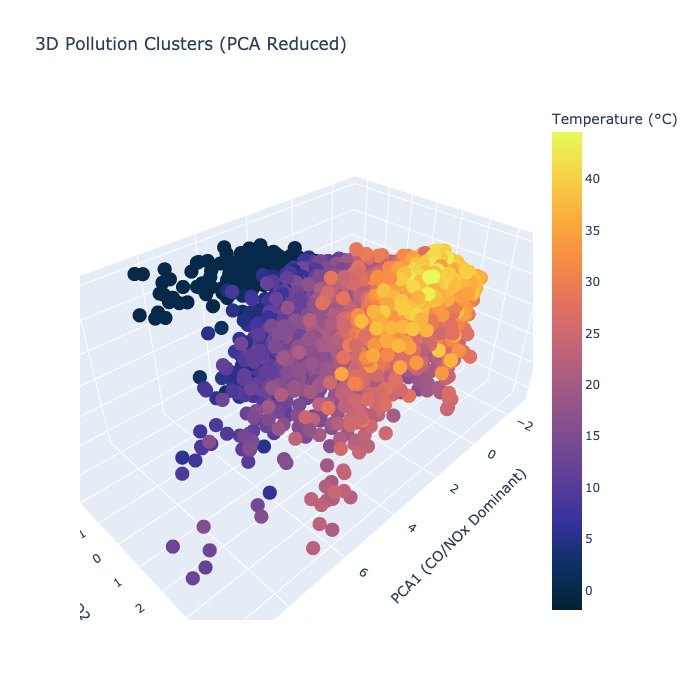

<Figure size 640x480 with 0 Axes>

In [10]:
# Select features (including temperature 't' and humidity 'ah')
features = df[['co_gt', 'nox_gt', 'c6h6_gt', 'no2_gt', 't', 'ah']].dropna()

# Scale features (critical for PCA, especially for 't' and 'ah')
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply PCA
pca = PCA(n_components=3)
components = pca.fit_transform(scaled_features)

# Create a DataFrame for plotting (with original temperature for coloring)
plot_df = pd.DataFrame({
    'PCA1': components[:, 0],
    'PCA2': components[:, 1],
    'PCA3': components[:, 2],
    'Temperature': features['t'],  # Original unscaled temperature for coloring
    'Humidity': features['ah']     # Optional: add humidity for hover data
})

# 3D Plot with Plotly
fig = px.scatter_3d(
    plot_df,
    x='PCA1',
    y='PCA2',
    z='PCA3',
    color='Temperature',  # Color by original temperature values
    title='3D Pollution Clusters (PCA Reduced)',
    labels={
        'PCA1': f'PCA1 ({pca.explained_variance_ratio_[0]:.1%})',
        'PCA2': f'PCA2 ({pca.explained_variance_ratio_[1]:.1%})',
        'PCA3': f'PCA3 ({pca.explained_variance_ratio_[2]:.1%})'
    },
    hover_data=['Humidity'],  # Show humidity on hover
    color_continuous_scale='thermal',  # Better colormap for temperature
    height=700
)

# Update layout for better readability
fig.update_layout(
    scene=dict(
        xaxis_title_text='PCA1 (CO/NOx Dominant)',
        yaxis_title_text='PCA2 (Benzene/NO2 Dominant)',
        zaxis_title_text='PCA3 (Temp/Humidity Dominant)'
    ),
    coloraxis_colorbar=dict(title='Temperature (°C)')
)

# Save the graph as a PNG
plt.savefig(
    'JoshuaSummers_PCA-exploration-scatter3D.png',
    dpi=300,               # High resolution
    transparent=False,     # Transparent background
    bbox_inches='tight'   # Remove extra whitespace
)
fig.show()

# Air Pollution Levels
---

This will visualize the air pollution levels collected based on the temperature at the time of collection. This will use a 3D scatter plot to show the clustering of data points.

## Average Air Pollution Levels by Temperature

This will visualize the average air pollution levels collected based on the temperature at the time of collection.
This will use a scatter plot to show the data clustering of CO, NOx, and Benzene as they relate to temperature. This will show all three in a 3D scatter plot and color them according to temperature to identify the temperature of the chemical at that spatial point.

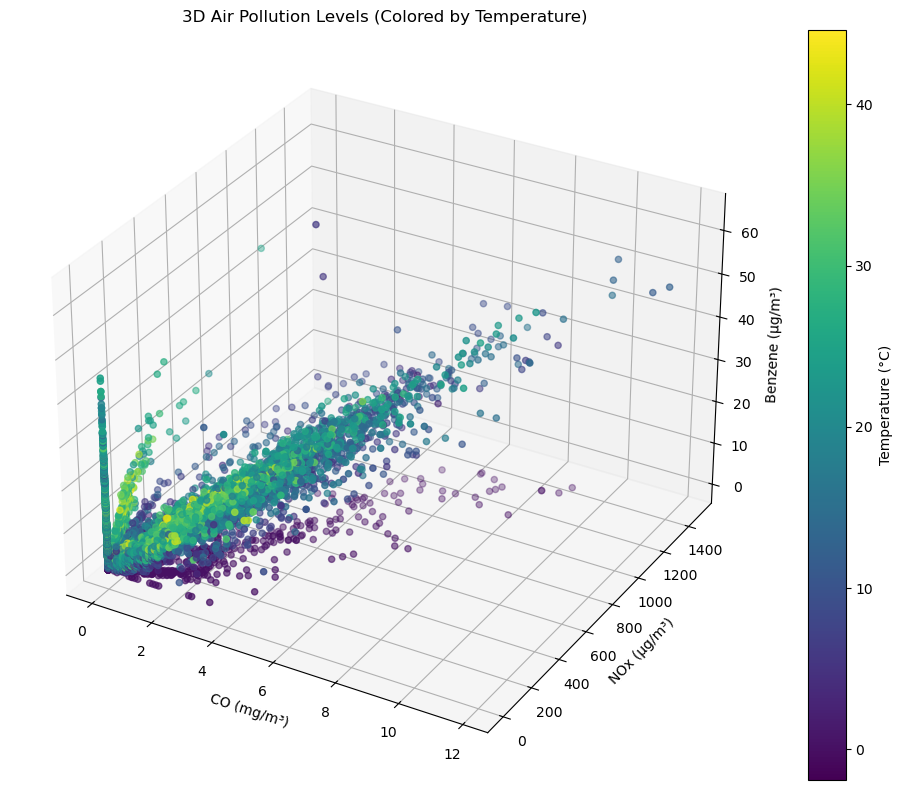

In [11]:
# Filter relevant columns
pollutants = df[['co_gt', 'nox_gt', 'c6h6_gt', 't']].dropna()

# Create figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    xs=pollutants['co_gt'],  # X = CO
    ys=pollutants['nox_gt'], # Y = NOx
    zs=pollutants['c6h6_gt'], # Z = Benzene
    c=pollutants['t'],  # Color = Temperature
    cmap='viridis',
    s=20  # Marker size
)

# Labels & title
ax.set_xlabel('CO (mg/m³)')
ax.set_ylabel('NOx (µg/m³)')
ax.set_zlabel('Benzene (µg/m³)')
ax.set_title('3D Air Pollution Levels (Colored by Temperature)')

# Colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Temperature (°C)')

# Save the graph as a PNG
plt.savefig(
    'JoshuaSummers_average-airpoluution-sensor-scatter3D.png',
    dpi=300,               # High resolution
    transparent=False,     # Transparent background
    bbox_inches='tight'   # Remove extra whitespace
)

plt.tight_layout()
plt.show()

## Average Air Pollution Levels 

This will visualize the average air pollution levels collected based on the temperature at the time of collection.
This will use a line plot to better show the changes.

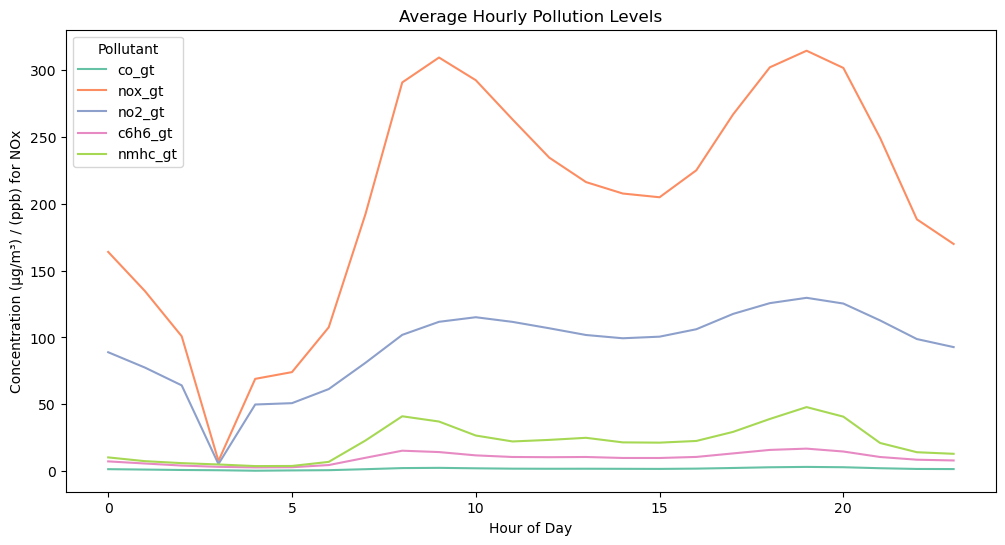

In [12]:
# Extract hour from time
df['hour'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.hour

# Calculate hourly averages and convert to long format
hourly_avg = df.groupby('hour')[['co_gt', 'nox_gt', 'no2_gt', 'c6h6_gt', 'nmhc_gt']].mean().reset_index()
melted_data = pd.melt(hourly_avg, id_vars=['hour'], var_name='variable', value_name='value')

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=melted_data, x='hour', y='value', hue='variable', 
             palette='Set2')

# Configure the figure settings
plt.title('Average Hourly Pollution Levels')
plt.ylabel('Concentration (µg/m³) / (ppb) for NOx')
plt.xlabel('Hour of Day')
plt.legend(title='Pollutant')

# Save the graph as a PNG
plt.savefig(
    'JoshuaSummers_average-airpoluution-sensor-lineplot.png',
    dpi=300,               # High resolution
    transparent=False,     # Transparent background
    bbox_inches='tight'   # Remove extra whitespace
)
# Show the visualization
plt.show()

## Sensor Air Pollution Levels by Hour

This will visualize the air pollution levels collected based on the temperature at the time of collection. This will use a 3D scatter plot to show the clustering of data points, but show it animated by the hour of day

This makes it easy to see which chemical pollutant had what temperature through the day, at given hour intervals, to show an animated change of the 3D spatial relationship between those chemicals and temperature.

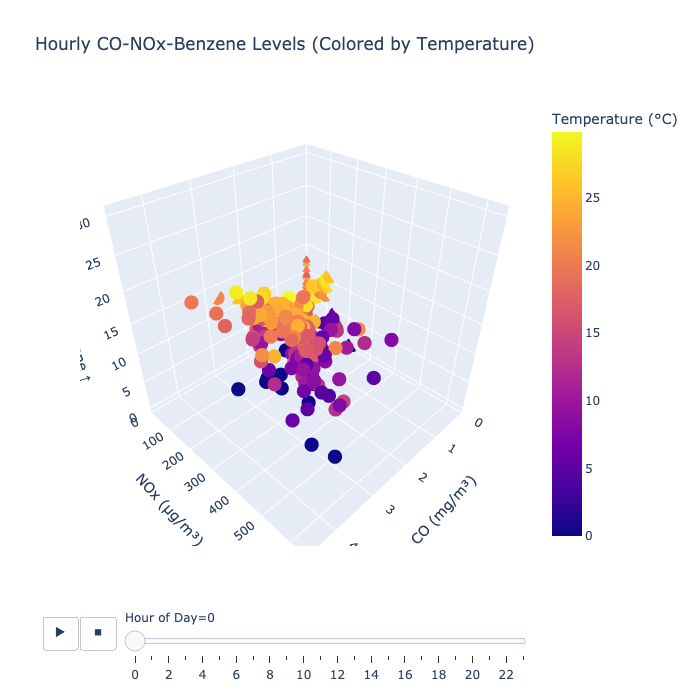

In [13]:
# Sort by datetime and ensure hour starts from 0 or 1
df_sorted = df.sort_values('datetime').copy()
df_sorted['hour'] = df_sorted['datetime'].dt.hour  # Ensure hour is extracted from datetime

# Define custom labels for each feature
column_labels = {
    'co_gt': 'CO (mg/m³)',
    'nox_gt': 'NOx (µg/m³)',
    'c6h6_gt': 'Benzene (µg/m³)',
    't': 'Temperature (°C)',
    'hour': 'Hour of Day'
}

# Animate by hour
fig = px.scatter_3d(
    df_sorted.sort_values('hour'),
    x='co_gt', 
    y='nox_gt', 
    z='c6h6_gt',
    animation_frame='hour',  # Animate by hour
    color='t',
    range_x=[0, df['co_gt'].quantile(0.95)],
    range_y=[0, df['nox_gt'].quantile(0.95)],
    title='Hourly CO-NOx-Benzene Levels (Colored by Temperature)',
    labels=column_labels,
    height=700
)

# Update the layout settings for the interactions
fig.update_layout(scene_camera=dict(up=dict(x=0, y=0, z=1)), 
                  scene=dict(zaxis_title='Benzene ↑'))

# Save the graph as a PNG using plotly's write_image
fig.write_image(
    'JoshuaSummers_hourly-co-nox-benzene-temperature-animated-scatter3D.png',
    scale=3,               # High resolution (equivalent to dpi)
    engine='kaleido'        # Recommended rendering engine
)

# Show the visualization
fig.show()

## Sensor Air Pollution Levels by Day

This will visualize the air pollution levels collected based on the temperature at the time of collection. This will use a 3D scatter plot to show the clustering of data points, but show it animated by the day of the week

This makes it easy to see which chemical pollutant had what temperature on which day, to show an animated change of the 3D spatial relationship between those chemicals and temperature.

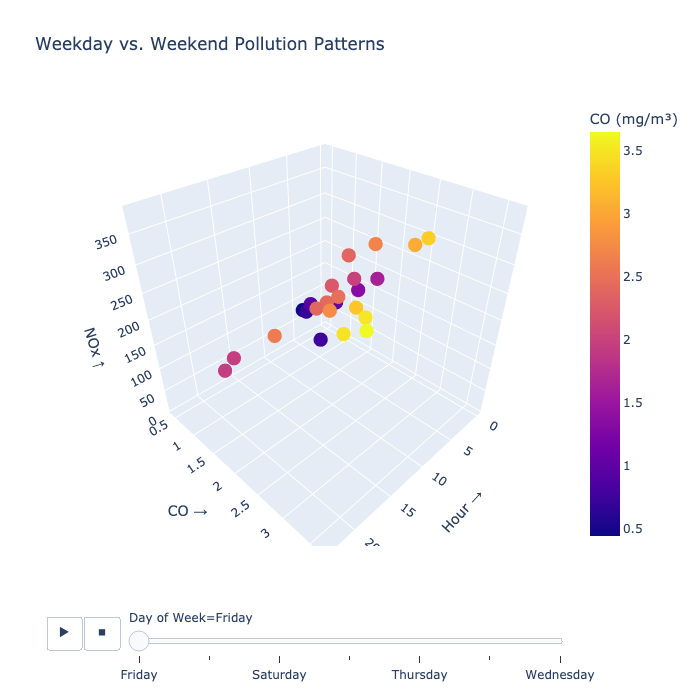

In [14]:
# Add weekday
df['weekday'] = df['datetime'].dt.day_name()

# Aggregate by weekday-hour
weekday_avg = df.groupby(['weekday', 'hour'])[['co_gt', 'nox_gt']].mean().reset_index()

# Define custom labels for each feature
column_labels = {
    'co_gt': 'CO (mg/m³)',
    'nox_gt': 'NOx (µg/m³)',
    't': 'Temperature (°C)',
    'hour': 'Hour of Day',
    'weekday': 'Day of Week'
}

# Animate by weekday
fig = px.scatter_3d(
    weekday_avg,
    x='hour',
    y='co_gt',
    z='nox_gt',
    animation_frame='weekday',  # Animate through weekdays
    color='co_gt',
    title='Weekday vs. Weekend Pollution Patterns',
    labels=column_labels,
    height=700
)

# Update the layout settings for the interactions
fig.update_layout(scene=dict(
    xaxis_title='Hour →',
    yaxis_title='CO →',
    zaxis_title='NOx ↑'
))

# Save the graph as a PNG using plotly's write_image
fig.write_image(
    'JoshuaSummers_polution-weekday-animated-scatter3D.png',
    scale=3,               # High resolution (equivalent to dpi)
    engine='kaleido'        # Recommended rendering engine
)

# Show the visualization
fig.show()

## Sensor Air Pollution Levels by Temperature Quintiles

This will visualize the air pollution levels collected based on the temperature at the time of collection. This will use a 3D scatter plot to show the clustering of data points, but show it animated by temperature quintiles (to create 5 groups).

This categorizes the temperature gradients into smaller groups, making it easier to classify and group them based on a range of temperatures. This still represents the same pollutant chemicals as they relate to temperature, but only against these quartiles.

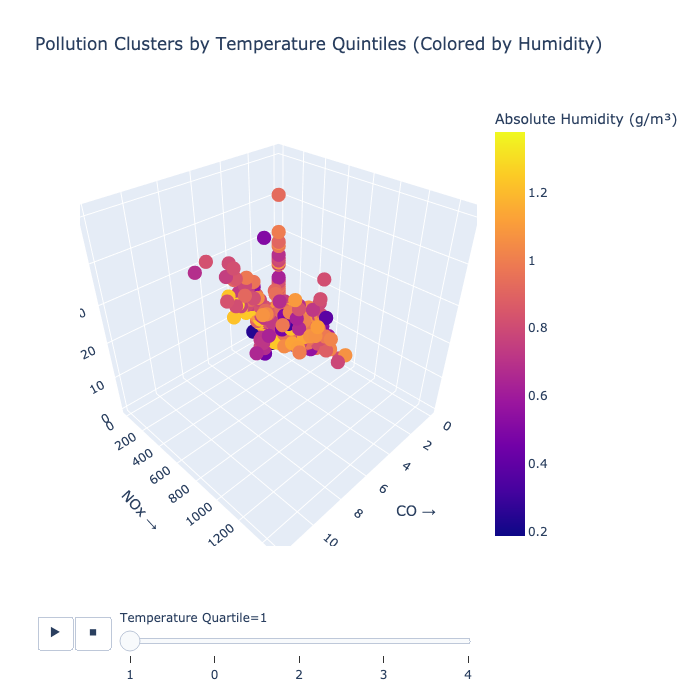

In [15]:
# Scale features for clustering
features = df[['co_gt', 'nox_gt', 'c6h6_gt', 't', 'ah']].dropna()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Animate by temperature quintiles
df['temp_q'] = pd.qcut(df['t'], q=5, labels=False)  # Quintiles

# Define custom labels for each feature
column_labels = {
    'co_gt': 'CO (mg/m³)',
    'c6h6_gt': 'Benzene (µg/m³)',
    'nox_gt': 'NOx (µg/m³)',
    't': 'Temperature (°C)',
    'ah': 'Absolute Humidity (g/m³)',
    'temp_q': 'Temperature Quartile'
}

# Render the 3D scatter
fig = px.scatter_3d(
    df.dropna(),
    x='co_gt',
    y='nox_gt',
    z='c6h6_gt',
    animation_frame='temp_q',  # Animate by temperature groups
    color='ah',
    title='Pollution Clusters by Temperature Quintiles (Colored by Humidity)',
    labels=column_labels,
    height=700
)

# Update the layout settings for the interactions
fig.update_layout(scene=dict(
    xaxis_title='CO →',
    yaxis_title='NOx →',
    zaxis_title='Benzene ↑'
))

# Save the graph as a PNG using plotly's write_image
fig.write_image(
    'JoshuaSummers_polution-temperature-quartiles-animated-scatter3D.png',
    scale=3,               # High resolution (equivalent to dpi)
    engine='kaleido'        # Recommended rendering engine
)

# Show the visualization
fig.show()

## Sensor Air Pollution Levels by Humidity Quintiles

This will visualize the air pollution levels collected based on the temperature at the time of collection. This will use a 3D scatter plot to show the clustering of data points, but show it animated by humidity quintiles (to create 5 groups).

This categorizes the humidity gradients into smaller groups, making it easier to classify and group them based on a range of humidities. This still represents the same pollutant chemicals as they relate to humidity, but only against these quartiles.

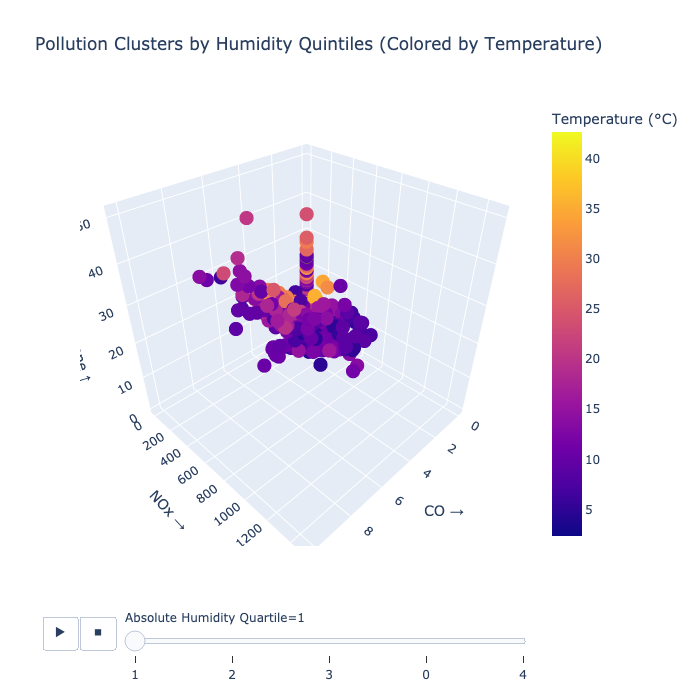

In [16]:
# Scale features for clustering
features = df[['co_gt', 'nox_gt', 'c6h6_gt', 't', 'ah']].dropna()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Animate by temperature quintiles
df['ah_q'] = pd.qcut(df['ah'], q=5, labels=False)  # Quintiles

# Define custom labels for each feature
column_labels = {
    'co_gt': 'CO (mg/m³)',
    'c6h6_gt': 'Benzene (µg/m³)',
    'nox_gt': 'NOx (µg/m³)',
    't': 'Temperature (°C)',
    'ah': 'Absolute Humidity (g/m³)',
    'ah_q': 'Absolute Humidity Quartile'
}

# Render the 3D scatter
fig = px.scatter_3d(
    df.dropna(),
    x='co_gt',
    y='nox_gt',
    z='c6h6_gt',
    animation_frame='ah_q',  # Animate by humidity groups
    color='t',
    title='Pollution Clusters by Humidity Quintiles (Colored by Temperature)',
    labels=column_labels,
    height=700
)

# Update the layout settings for the interactions
fig.update_layout(scene=dict(
    xaxis_title='CO →',
    yaxis_title='NOx →',
    zaxis_title='Benzene ↑'
))

# Save the graph as a PNG using plotly's write_image
fig.write_image(
    'JoshuaSummers_polution-humidity-quartiles-animated-scatter3D.png',
    scale=3,               # High resolution (equivalent to dpi)
    engine='kaleido'        # Recommended rendering engine
)

# Show the visualization
fig.show()

## Sensor Interactive Air Pollution Levels

This will visualize the air pollution levels collected based on the temperature at the time of collection. This will use a 3D scatter plot to show the clustering of data points, but have interactive responses to hover events.

This visualization still represents the same three pollutant chemicals, and is still regarding temperature, but the 3D graph is interactive, and allows moving the mouse over data points to get specific information about that spatial cell.

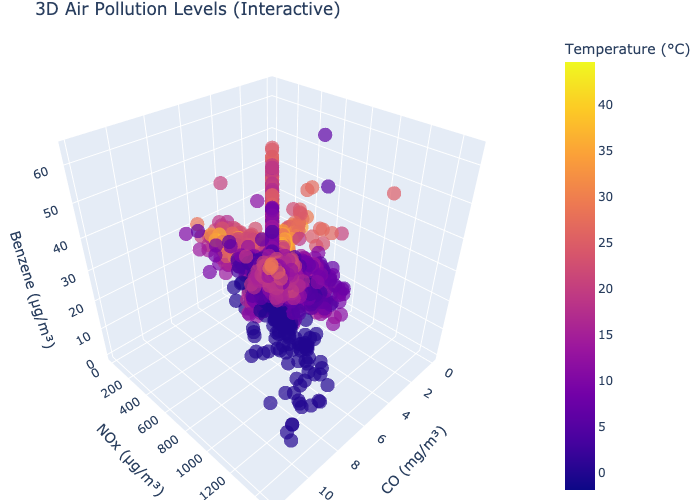

In [17]:
# Define custom labels for each feature
column_labels = {
    'co_gt': 'CO (mg/m³)',
    'c6h6_gt': 'Benzene (µg/m³)',
    'nox_gt': 'NOx (µg/m³)',
    't': 'Temperature (°C)'
}

# Generate the 3D Scatter plotly
fig = px.scatter_3d(
    df,
    x='co_gt',
    y='nox_gt',
    z='c6h6_gt',
    color='t',
    title='3D Air Pollution Levels (Interactive)',
    labels=column_labels,
    opacity=0.7,
    hover_data=['datetime']  # Show time on hover
)

# Update the layout settings
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))

# Save the graph as a PNG using plotly's write_image
fig.write_image(
    'JoshuaSummers_polution-levels-interactive-scatter3D.png',
    scale=3,               # High resolution (equivalent to dpi)
    engine='kaleido'        # Recommended rendering engine
)

# Show the visualization
fig.show()

## CO and NOx Levels over Time

This will visualize the air pollution levels collected based on the temperature at the time of collection. This will use a 3D scatter plot to show the CO and NOx levels over time and according to temperature.

This visualization specifically focuses on CO and NOx over time and as they relate to temperature. This gives us time as a different dimension we can observe (like a 3D timescale). This is also interactive and allows for hovering over a data point to get the specific values for that spatial coordinate.

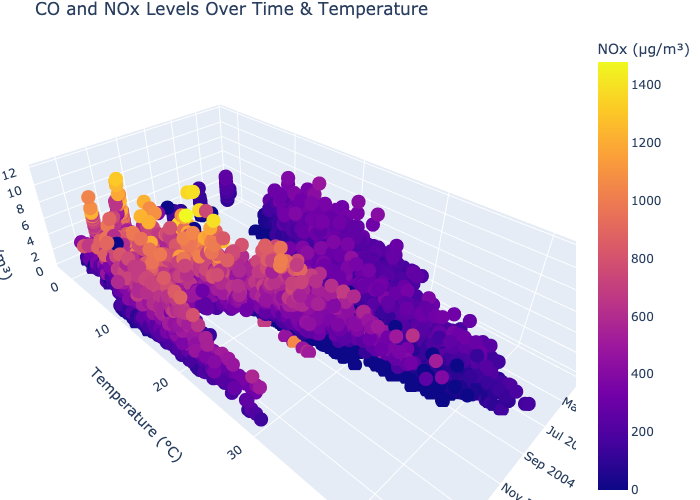

In [18]:
# Define custom labels for each feature
column_labels = {
    'co_gt': 'CO (mg/m³)',
    'nox_gt': 'NOx (µg/m³)',
    't': 'Temperature (°C)',
    'datetime': 'Time'
}

# Generate the 3D Scatter plotly
fig = px.scatter_3d(
    df,
    x='datetime',  # Time on X-axis
    y='t',          # Temperature on Y-axis
    z='co_gt',      # CO on Z-axis
    color='nox_gt',  # Color by NOx levels
    title='CO and NOx Levels Over Time & Temperature',
    labels=column_labels
)

# Update the layout settings
fig.update_layout(margin=dict(l=0, r=0, b=0, t=30))

# Save the graph as a PNG using plotly's write_image
fig.write_image(
    'JoshuaSummers_co-nox-levels-time-temperature-scatter3D.png',
    scale=3,               # High resolution (equivalent to dpi)
    engine='kaleido'        # Recommended rendering engine
)

# Show the visualization
fig.show()

## Sensor Daily CO and NOx Trends

This will visualize the air pollution levels collected based on the temperature at the time of collection. This will use a 3D scatter plot to show the clustering of data points, but showing trends for CO and NOx.

This visualization gives a dense animation of the daily change of CO and NOx over the day, but with many intervals. This gives a granular trend analysis of these chemicals as they change over time, and as they relate to temperature.

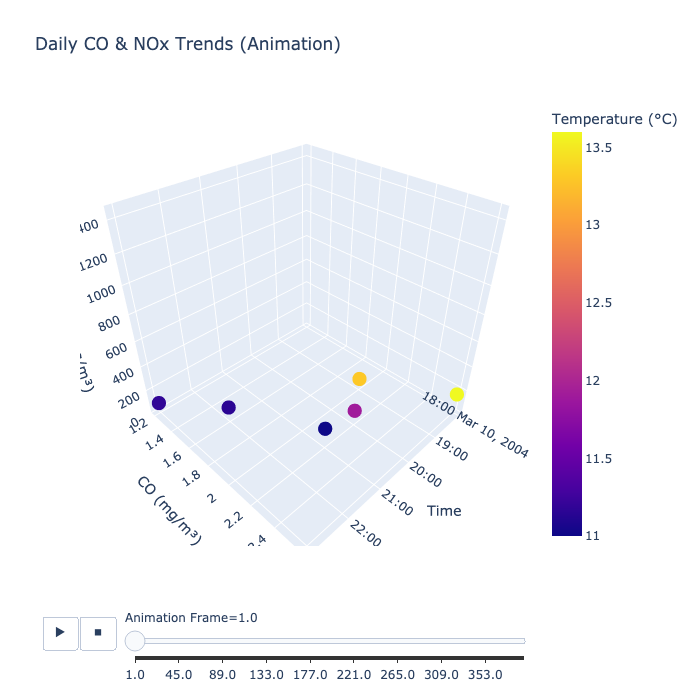

In [19]:
# Animate by day
df['byDay'] = df['datetime'].dt.date.rank(method='dense')

# Define custom labels for each feature
column_labels = {
    'co_gt': 'CO (mg/m³)',
    'nox_gt': 'NOx (µg/m³)',
    't': 'Temperature (°C)',
    'datetime': 'Time',
    'byDay': 'Animation Frame'
}

# Generate the 3D Scatter plotly
fig = px.scatter_3d(
    df.sort_values('datetime'),
    x='datetime',
    y='co_gt',
    z='nox_gt',
    animation_frame='byDay',  
    color='t',
    title='Daily CO & NOx Trends (Animation)',
    labels=column_labels,
    range_z=[0, df['nox_gt'].max()],
    height=700
)

# Save the graph as a PNG using plotly's write_image
fig.write_image(
    'JoshuaSummers_co-nox-temperature-trends-animated-scatter3D.png',
    scale=3,               # High resolution (equivalent to dpi)
    engine='kaleido'        # Recommended rendering engine
)

# Show the visualization
fig.show()

## Sensor Daily CO and NOx Levels

This will visualize the air pollution levels collected based on the temperature at the time of collection. This will use a 3D scatter plot to show the clustering of data points, but focused on CO levels vs Temperature and Humidity in regards to NOx.

This visualization takes an entirely different perspective, and shows us CO and temperature over time, but as they relate to relative NOx chemicals. This visualization is interactive and allows for specific data points when hovering over a spatial coordinate.

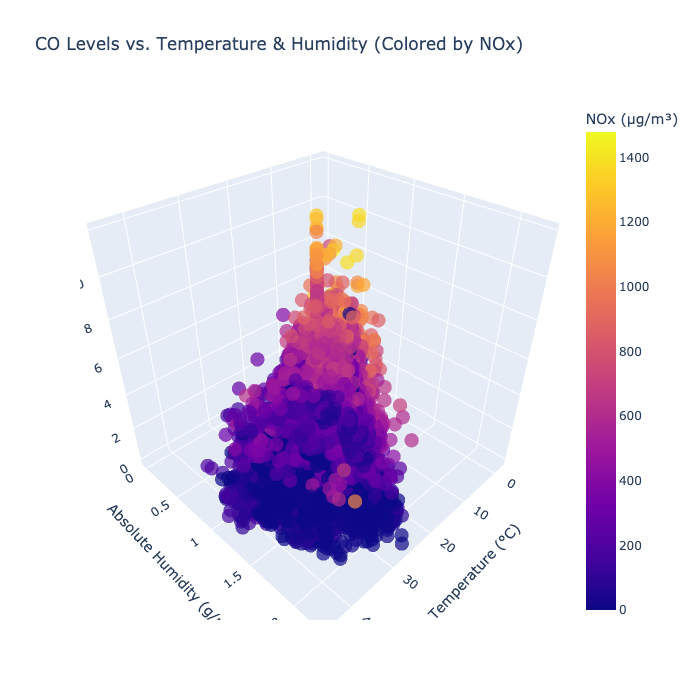

In [20]:
# Define custom labels for each feature
column_labels = {
    'co_gt': 'CO (mg/m³)',
    'nox_gt': 'NOx (µg/m³)',
    't': 'Temperature (°C)',
    'datetime': 'Time',
    'ah': 'Absolute Humidity (g/m³)'
}

# Generate the 3D Scatter plotly
fig = px.scatter_3d(
    df,
    x='t',                  # Temperature (X-axis)
    y='ah',                 # Absolute Humidity (Y-axis)
    z='co_gt',              # CO (Z-axis)
    color='nox_gt',         # Color by NOx levels
    title='CO Levels vs. Temperature & Humidity (Colored by NOx)',
    labels=column_labels,
    hover_data=['datetime', 'c6h6_gt'],  # Show benzene on hover
    opacity=0.7,
    height=700
)

# Update the layout settings
fig.update_layout(scene=dict(zaxis_title='CO (mg/m³) →'))

# Save the graph as a PNG using plotly's write_image
fig.write_image(
    'JoshuaSummers_co-temperature-humidity-nox-scatter3D.png',
    scale=3,               # High resolution (equivalent to dpi)
    engine='kaleido'        # Recommended rendering engine
)

# Show the visualization
fig.show()

## Sensor Daily CO and NOx Levels

This will visualize the air pollution levels collected based on the temperature at the time of collection. This will use a 3D scatter plot to show the clustering of data points, but focused on CO levels vs NOx and O₃.

This visualization looks at CO and NOx, but this time it inspects Ozone instead of Benzene. These chemicals show a relationship over time and concerning temperature. 

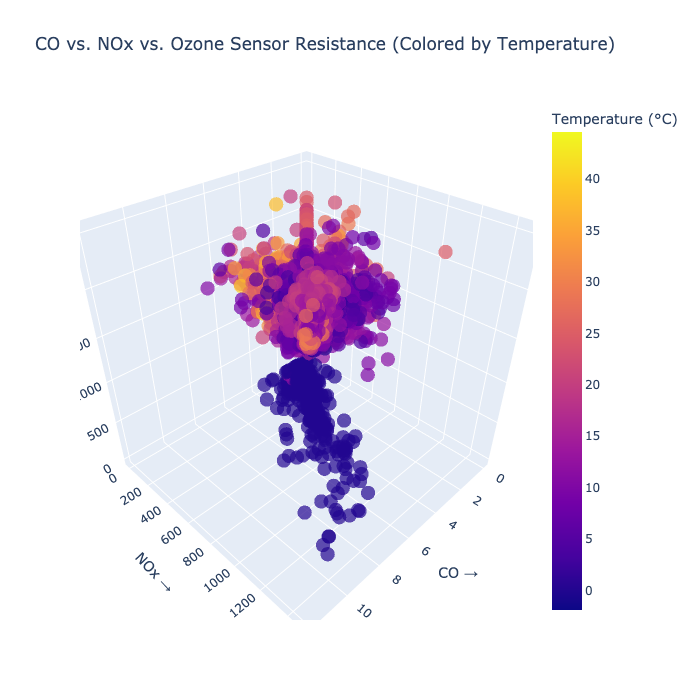

In [21]:
# Define custom labels for each feature
column_labels = {
    'co_gt': 'CO (mg/m³)',
    'nox_gt': 'NOx (µg/m³)',
    't': 'Temperature (°C)',
    'datetime': 'Time',
    'pt08.s5_o3': 'O₃'
}

# Generate the 3D Scatter plotly
fig = px.scatter_3d(
    df,
    x='co_gt',          # CO (X-axis)
    y='nox_gt',         # NOx (Y-axis)
    z='pt08.s5_o3',     # Ozone sensor (Z-axis)
    color='t',          # Color by temperature
    title='CO vs. NOx vs. Ozone Sensor Resistance (Colored by Temperature)',
    labels=column_labels,
    hover_data=['datetime'],
    opacity=0.7,
    height=700
)

# Update the layout settings
fig.update_layout(scene=dict(
    zaxis_title='Ozone Sensor (O₃) →',
    xaxis_title='CO →',
    yaxis_title='NOx →'
))

# Save the graph as a PNG using plotly's write_image
fig.write_image(
    'JoshuaSummers_co-nox-benzene-resistance-temperature-interactive-scatter3D.png',
    scale=3,               # High resolution (equivalent to dpi)
    engine='kaleido'        # Recommended rendering engine
)

# Show the visualization
fig.show()

## Sensor Daily Benzene and NO₂ Levels

This will visualize the air pollution levels collected based on the temperature at the time of collection. This will use a 3D scatter plot to show the clustering of data points, but focused on C6H6 (Benzene) and NO₂ versus temperature regarding NOx.

This visualization takes an entirely different perspective, and shows us Benzene and temperature and NOx, but as they relate to relative NOx chemicals. This visualization is interactive and allows for specific data points when hovering over a spatial coordinate.

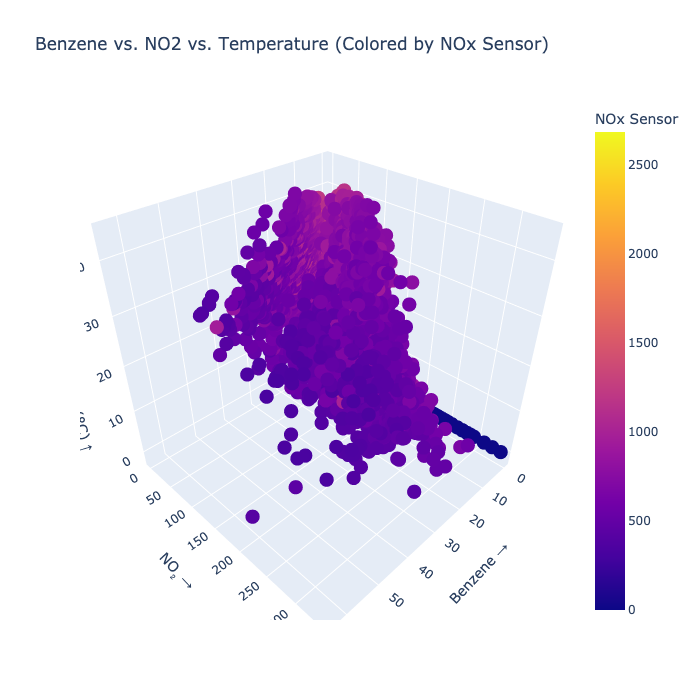

In [22]:
# Define custom labels for each feature
column_labels = {
    'co_gt': 'CO (mg/m³)',
    'nox_gt': 'NOx (µg/m³)',
    't': 'Temperature (°C)',
    'datetime': 'Time',
    'c6h6_gt': 'Benzene (µg/m³)',
    'no2_gt': 'NO₂ (µg/m³)',
    'pt08.s3_nox': 'NOx Sensor'
}

# Generate the 3D Scatter plotly
fig = px.scatter_3d(
    df,
    x='c6h6_gt',        # Benzene (X-axis)
    y='no2_gt',         # NO2 (Y-axis)
    z='t',              # Temperature (Z-axis)
    color='pt08.s3_nox', # Color by NOx sensor
    title='Benzene vs. NO2 vs. Temperature (Colored by NOx Sensor)',
    labels=column_labels,
    hover_data=['datetime'],
    height=700
)

# Update the layout settings
fig.update_layout(scene=dict(
    xaxis_title='Benzene →',
    yaxis_title='NO₂ →',
    zaxis_title='Temperature (°C) ↑'
))

# Save the graph as a PNG using plotly's write_image
fig.write_image(
    'JoshuaSummers_benzene-no2-temperature-nox-interactive-scatter3D.png',
    scale=3,               # High resolution (equivalent to dpi)
    engine='kaleido'        # Recommended rendering engine
)

# Show the visualization
fig.show()